Получим обучающий и тестовый датасеты, предварительно для удобства загруженные на Github. Проверив данные датасета, видим что пропуски встречаются в менее чем 1000 строк из более 10000, значит, их можно удалить. Также удаляем столбец ID из тестового датасета, чтобы сделать его структуру идентичной обучающему. Проверим параметры на предмет выбросов.

<class 'pandas.core.frame.DataFrame'>
Index: 10487 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           10487 no

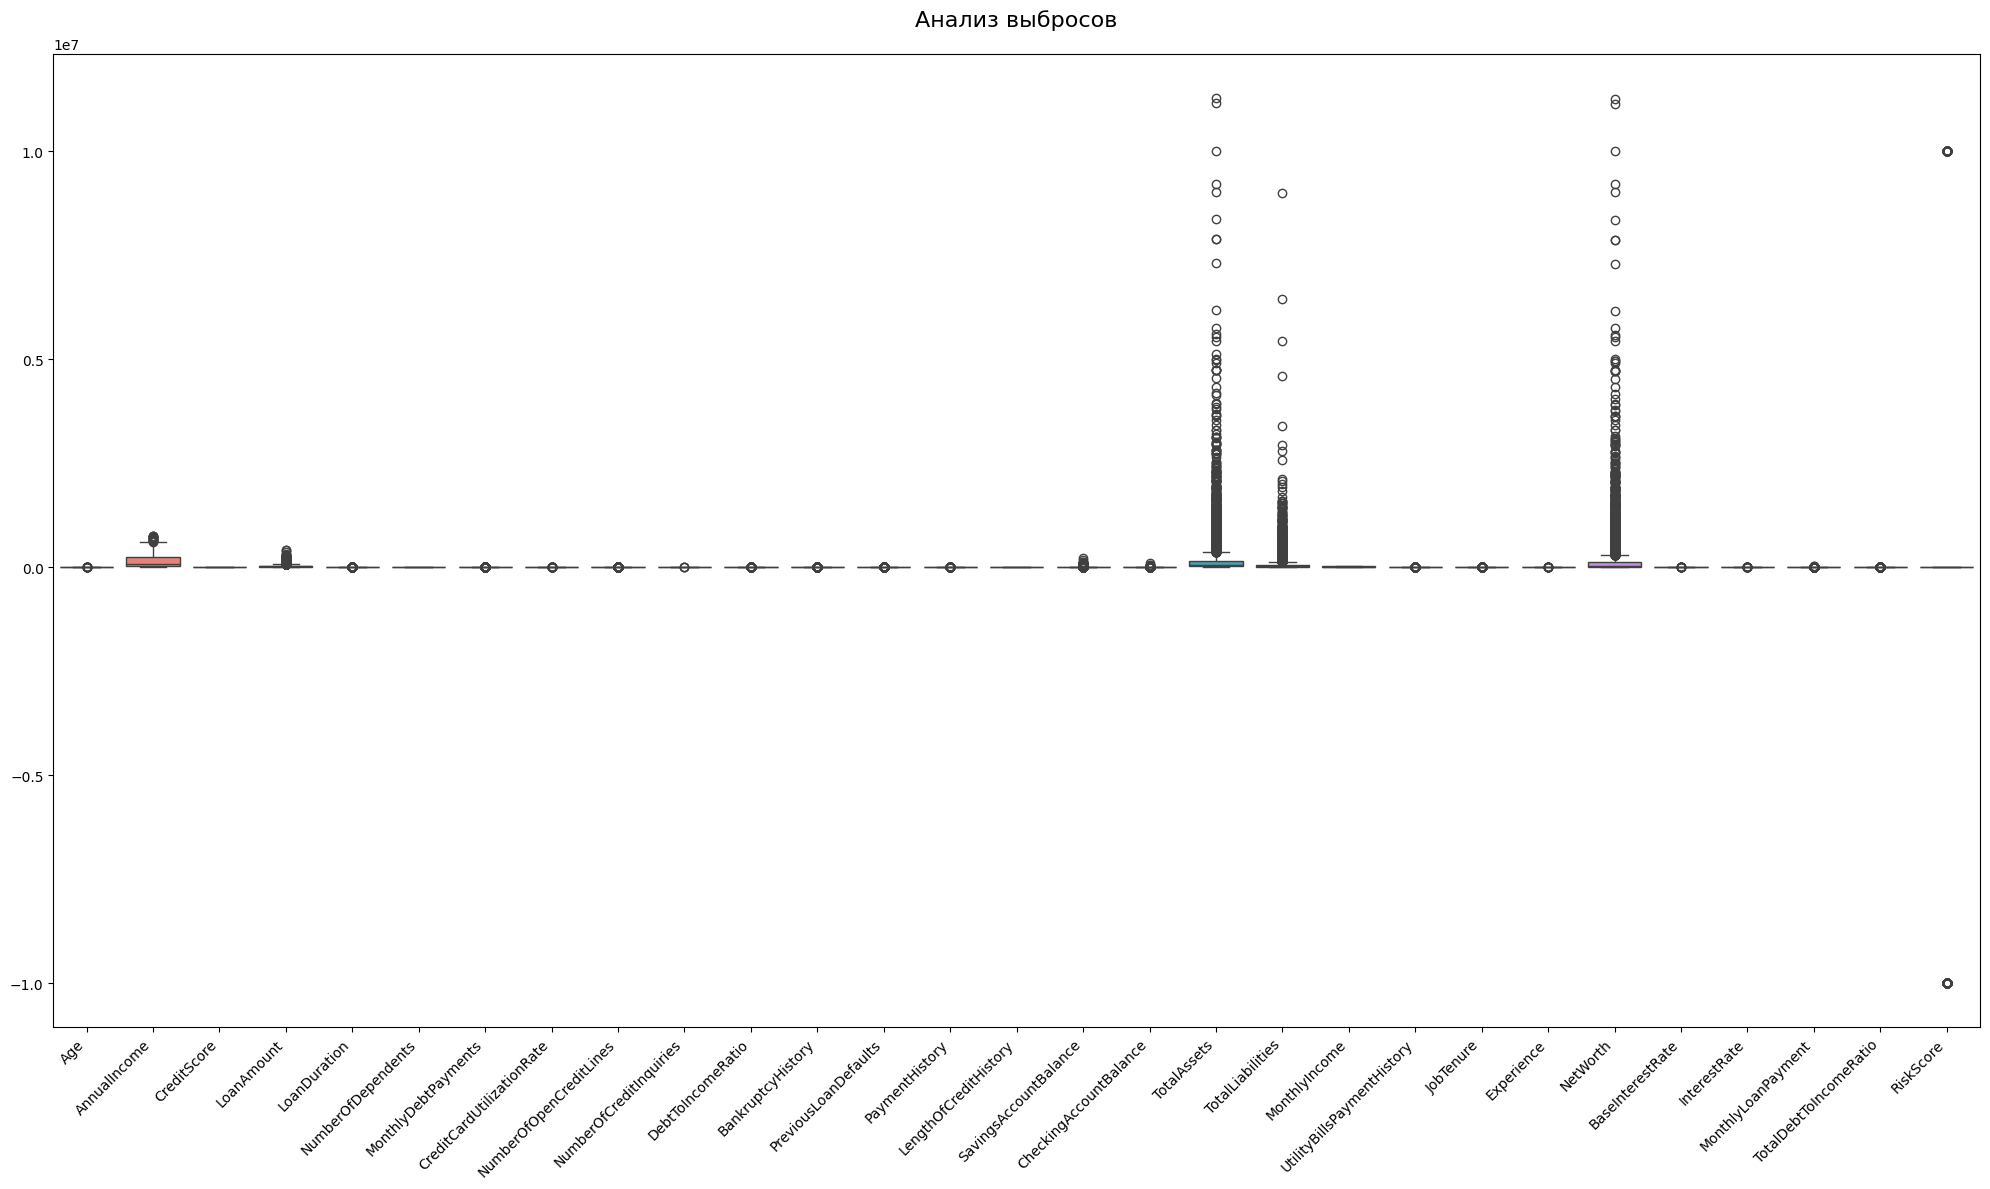

In [39]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/train.csv").dropna(how='all')

df.info()
df = df.dropna()
test_df = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/test.csv").dropna(how='all').drop(columns=['ID'])

df.info()


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(20, 12))
sns.boxplot(df)
plt.title("Анализ выбросов", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

В целевом параметре обнаружилось два неестественно больших выброса, обрежем их. Также сразу удалим из рассмотрения признак ApplicationDate, как явно бесполезный для анализа.

In [40]:
import seaborn as sns

df = df[abs(df['RiskScore']) < 200].drop(columns=['ApplicationDate'])
test_df = test_df.drop(columns=['ApplicationDate'])

Преобразуем категориальные признаки к числовому виду с помощью LabelEncoder.

In [41]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in df.select_dtypes(include=['object']).columns.tolist():
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

for column in test_df.select_dtypes(include=['object']).columns.tolist():
    le = LabelEncoder()
    test_df[column] = le.fit_transform(test_df[column])

Так как обучение только на базовом наборе признаков не дало нужного покказателя MSE, было решено добавить нелиненйные комбинации существующих признаков в качестве новых. Используемые комбинации (3.1, 1/3 степени, попарные произведения, логирфмы и некоторые специфические смысловые комбинации) подбирались исходя из того, что добавление каждой очередной группы незначительно (на десятые доли) либо значительно (на несколько единиц) уменьшало MSE. В случае с попарными произведениями ограничение (– 5) было выбрано исходя из того, что при оставлении большего числа попарных произведений, MSE на обучающей выборке сильно уменьшалось, но на тестовой сильно увеличивалось (по всей видимости, происходило переобучение). Оставление же меньшего числа попарных произведений сильно увеличивало MSE по всем выборкам.

In [42]:
cols = test_df.select_dtypes(include=['number']).columns.tolist()
for col in test_df.select_dtypes(include=['number']).columns.tolist():
  df[col + '_cube'] = df[col] ** 3.1
  df[col + '_div_by_cube'] = df[col] ** (1/3)
  test_df[col + '_cube'] = test_df[col] ** 3.1
  test_df[col + '_div_by_cube'] = test_df[col] ** (1/3)

for ncol1 in range(len(cols) - 5):
  for ncol2 in range(ncol1 + 1, len(cols) - 5):
    col1 = cols[ncol1]
    col2 = cols[ncol2]
    df[col1 + '_' + col2] = df[col1] * df[col2]
    test_df[col1 + '_' + col2] = test_df[col1] * test_df[col2]

def create_financial_stability_features(df):

    # Коэффициент финансовой независимости
    df['FinancialIndependenceRatio'] = (df['NetWorth'] + 1) / (df['TotalLiabilities'] + 1)

    # Покрытие долгов активами
    df['AssetDebtCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + 1)

    # "Финансовая подушка" - сбережения относительно дохода
    df['FinancialCushion'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / \
                            (df['AnnualIncome'] / 12 + 1)

    # Платежная способность (сколько месяцев можно жить на сбережения)
    df['MonthsOfSavings'] = (df['SavingsAccountBalance'] + df['CheckingAccountBalance']) / \
                           (df['MonthlyDebtPayments'] + 1)

    # Риск ликвидности
    df['LiquidityRisk'] = (df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']) / \
                         (df['MonthlyIncome'] + 1)

    # Чистый денежный поток
    df['NetCashFlow'] = df['MonthlyIncome'] - df['MonthlyDebtPayments'] - df['MonthlyLoanPayment']
    df['CashFlowAdequacy'] = df['NetCashFlow'] / (df['MonthlyLoanPayment'] + 1)

    return df

def create_debt_risk_features(df):

    # Общая долговая нагрузка (все долги)
    df['TotalDebtBurden'] = df['MonthlyDebtPayments'] + df['MonthlyLoanPayment']
    df['TotalDebtToIncome'] = df['TotalDebtBurden'] / (df['MonthlyIncome'] + 1)

    # "Долговая ловушка" - отношение долгов к активам
    df['DebtTrapRisk'] = df['TotalLiabilities'] / (df['TotalAssets'] + 1)

    # Риск дефолта на основе CreditScore и долгов
    df['DefaultRiskScore'] = ((850 - df['CreditScore']) / 850) * df['DebtToIncomeRatio']

    # Нагрузка от нового кредита
    df['NewLoanBurden'] = df['MonthlyLoanPayment'] / (df['MonthlyIncome'] + 1)

    # Соотношение кредита к доходу
    df['LoanToIncomeAnnual'] = df['LoanAmount'] / (df['AnnualIncome'] + 1)

    return df

def add_comprehensive_binning_features(df):

    df_enhanced = df.copy()

    df_enhanced['DebtToIncome_Binned'] = pd.cut(
        df_enhanced['DebtToIncomeRatio'],
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=[1, 2, 3, 4, 5]
    ).astype(float)

    # Отношение кредита к доходу
    loan_to_income = df_enhanced['LoanAmount'] / (df_enhanced['AnnualIncome'] + 1)
    df_enhanced['LoanToIncome_Binned'] = pd.cut(
        loan_to_income,
        bins=[0, 0.5, 1.0, 1.5, 2.0, 10],
        labels=[1, 2, 3, 4, 5]
    ).astype(float).fillna(3)

    # Уровень сбережений
    savings_ratio = df_enhanced['SavingsAccountBalance'] / (df_enhanced['AnnualIncome'] + 1)
    df_enhanced['SavingsRatio_Binned'] = pd.cut(
        savings_ratio,
        bins=[0, 0.1, 0.25, 0.5, 1.0, 100],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    # Покрытие долгов активами
    asset_coverage = df_enhanced['TotalAssets'] / (df_enhanced['TotalLiabilities'] + 1)
    df_enhanced['AssetCoverage_Binned'] = pd.cut(
        asset_coverage,
        bins=[0, 0.5, 1.0, 2.0, 5.0, 1000],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    # Чистая стоимость относительно дохода
    networth_ratio = df_enhanced['NetWorth'] / (df_enhanced['AnnualIncome'] + 1)
    df_enhanced['NetWorthRatio_Binned'] = pd.cut(
        networth_ratio,
        bins=[-1000, 0, 0.5, 1.0, 2.0, 1000],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    # Использование кредитного лимита
    df_enhanced['CreditUtilization_Binned'] = pd.cut(
        df_enhanced['CreditCardUtilizationRate'],
        bins=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
        labels=[1, 2, 3, 4, 5, 6]
    ).astype(float).fillna(3)

    # Количество кредитных линий
    df_enhanced['CreditLines_Binned'] = pd.cut(
        df_enhanced['NumberOfOpenCreditLines'],
        bins=[0, 1, 3, 5, 7, 10, 100],
        labels=[1, 2, 3, 4, 5, 6]
    ).astype(float).fillna(3)

    # Частота кредитных запросов
    df_enhanced['CreditInquiries_Binned'] = pd.cut(
        df_enhanced['NumberOfCreditInquiries'],
        bins=[-1, 0, 1, 2, 3, 5, 100],
        labels=[1, 2, 3, 4, 5, 6]
    ).astype(float).fillna(2)

    # Длительность кредитной истории
    df_enhanced['CreditHistoryLength_Binned'] = pd.cut(
        df_enhanced['LengthOfCreditHistory'],
        bins=[0, 2, 5, 7, 10, 15, 100],
        labels=[6, 5, 4, 3, 2, 1]
    ).astype(float).fillna(4)

    # Качество платежной истории
    payment_quality = df_enhanced['PaymentHistory'] / (df_enhanced['LengthOfCreditHistory'] + 1)
    df_enhanced['PaymentQuality_Binned'] = pd.cut(
        payment_quality,
        bins=[0, 0.5, 0.7, 0.85, 0.95, 1.0],
        labels=[5, 4, 3, 2, 1]
    ).astype(float).fillna(3)

    return df_enhanced

df = add_comprehensive_binning_features(create_debt_risk_features(create_financial_stability_features(df)))
test_df = add_comprehensive_binning_features(create_debt_risk_features(create_financial_stability_features(test_df)))

def add_log_transformations(df, test_df):
    df_log = df.copy()
    test_log = test_df.copy()

    for col in cols:
        if (df[col] > 0).all():
            df_log[f'Log_{col}'] = np.log1p(df[col])
            test_log[f'Log_{col}'] = np.log1p(test_df[col])
        else:
            min_val = df[col].min()
            if min_val <= 0:
                shift = abs(min_val) + 1
                df_log[f'Log_{col}'] = np.log1p(df[col] + shift)
                test_log[f'Log_{col}'] = np.log1p(test_df[col] + shift)

    return df_log, test_log

df, test_df = add_log_transformations(df, test_df)


Далее произведём общую обработку выбросов с использованием метода винсоризации. Процентили также подобраны для достижения оптимального MSE.

In [43]:
cols_to_cap = df.select_dtypes(include=[np.number]).columns.drop('RiskScore')

for col in cols_to_cap:

    lower_limit = df[col].quantile(0.02)

    upper_limit = df[col].quantile(0.99)

    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

    test_df[col] = test_df[col].clip(lower=lower_limit, upper=upper_limit)

Рассмотрим параметры с высокой корреляцией с целевым, каковых после добавления нелинейных комбинаций оказалось довольно много. Параметры с низкой корреляцией удалим.

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


correlation_with_target = df.corr()['RiskScore'].abs().sort_values(ascending=False)
print("Корреляция с RiskScore:")
print(correlation_with_target.head(15))

low_corr_features = correlation_with_target[correlation_with_target < 0.05].index.tolist()
print(len(low_corr_features))
df = df.drop(columns=low_corr_features)
test_df = test_df.drop(columns=low_corr_features)

Корреляция с RiskScore:
RiskScore                             1.000000
Log_MonthlyIncome                     0.846699
Log_AnnualIncome                      0.845739
MonthlyIncome_div_by_cube             0.831218
AnnualIncome_div_by_cube              0.830519
CreditScore                           0.785425
CreditScore_cube                      0.784622
CreditScore_MonthlyIncome             0.782298
AnnualIncome_CreditScore              0.782186
NetCashFlow                           0.778771
TotalDebtToIncomeRatio_div_by_cube    0.778732
MonthlyIncome                         0.770608
CreditScore_div_by_cube               0.770588
AnnualIncome                          0.770431
Log_BaseInterestRate                  0.764539
Name: RiskScore, dtype: float64
288


Рассмотрим признаки с высокой попарной корреляцией и удалим те из них, которые имеют незначительную корреляцию с целевым признаком. Понижение порога ниже 0.98 существенно ухудшало MSE.

In [45]:

def get_highly_correlated_features_to_remove(df, corr_threshold=0.9, target_corr_threshold=0.08, target_column='RiskScore'):
    corr_matrix = df.corr().abs()

    target_correlations = corr_matrix[target_column].drop(target_column)

    upper_triangle = corr_matrix.where(
        np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    )

    columns_to_remove = set()

    for col in upper_triangle.columns:
        if col == target_column:
            continue

        high_corr_with = upper_triangle[col][upper_triangle[col] > corr_threshold]

        for correlated_col in high_corr_with.index:
            if correlated_col == target_column:
                continue

            col_target_corr = target_correlations[col]
            correlated_col_target_corr = target_correlations[correlated_col]

            if col_target_corr < target_corr_threshold and correlated_col_target_corr < target_corr_threshold:
                if col_target_corr < correlated_col_target_corr:
                    columns_to_remove.add(col)
                else:
                    columns_to_remove.add(correlated_col)
            elif col_target_corr < target_corr_threshold and correlated_col_target_corr >= target_corr_threshold:
                columns_to_remove.add(col)
            elif col_target_corr >= target_corr_threshold and correlated_col_target_corr < target_corr_threshold:
                columns_to_remove.add(correlated_col)

    return list(columns_to_remove)

columns_to_remove = get_highly_correlated_features_to_remove(
    df,
    corr_threshold=0.98
)

print(f"Признаки для удаления: {columns_to_remove}")

df = df.drop(columns=columns_to_remove)
test_df = test_df.drop(columns=columns_to_remove)

Признаки для удаления: ['Log_PreviousLoanDefaults', 'LengthOfCreditHistory_div_by_cube', 'UtilityBillsPaymentHistory_EmploymentStatus', 'PreviousLoanDefaults_PaymentHistory', 'CreditCardUtilizationRate_div_by_cube', 'PreviousLoanDefaults_div_by_cube', 'PreviousLoanDefaults_cube', 'Log_CreditCardUtilizationRate', 'EmploymentStatus_div_by_cube', 'EmploymentStatus', 'PreviousLoanDefaults']


Стандартизирем нецелевые признаки для приведения признаков к одному масштабу с помощью StandardScaler.

In [46]:
from sklearn.preprocessing import StandardScaler
numeric_cols_to_scale = [col for col in df.columns if col != 'RiskScore']
scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numeric_cols_to_scale] = scaler.fit_transform(df[numeric_cols_to_scale])
df = df_standardized

test_df_standardized = test_df.copy()
test_df_standardized[numeric_cols_to_scale] = scaler.transform(test_df[numeric_cols_to_scale])
test_df = test_df_standardized

Разделяем данные на обучающую и валидационную выборки, убираем целевой параметр, обучаем модель и проверяем метрики на обеих выборках. Разница в MSE показывает незначительную степень переобучения, однако недостаточную, чтобы испортить выигрыш в MSE на тестовой выборке.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

X = df.drop('RiskScore', axis=1)
y = df['RiskScore']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print("КАЧЕСТВО МОДЕЛИ НА ОБУЧАЮЩИХ ДАННЫХ:")
print(f"R² score: {r2_score(y_train, y_train_pred):.4f}")
print(f"MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")

print("\n" + "="*50)
print("КАЧЕСТВО МОДЕЛИ НА ВАЛИДАЦИОННЫХ ДАННЫХ:")
print(f"R² score: {r2_score(y_val, y_val_pred):.4f}")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")


КАЧЕСТВО МОДЕЛИ НА ОБУЧАЮЩИХ ДАННЫХ:
R² score: 0.9233
MSE: 22.7786
RMSE: 4.7727
MAE: 3.6128

КАЧЕСТВО МОДЕЛИ НА ВАЛИДАЦИОННЫХ ДАННЫХ:
R² score: 0.9180
MSE: 24.6398
RMSE: 4.9638
MAE: 3.6651


Получаем предсказания по тестовому датасету, формируем требуемый формат ответа. Также сравниваем по метрикам результат с другим результатом с известным MSE (около 25), полученным ранее, чтобы исключить неожиданное поведения текущего результата.

In [48]:
ty_pred = model.predict(test_df)

result = pd.DataFrame({
    'ID': range(len(ty_pred)),
    'RiskScore': ty_pred
})


y_test = pd.read_csv("https://raw.githubusercontent.com/MMVlasko/ml/refs/heads/main/predictions%20(7)%20(2).csv").drop(columns=['ID'])
print(f"R² score: {r2_score(y_test, ty_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, ty_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ty_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, ty_pred):.4f}")

result.to_csv('predictions.csv', index=False)

R² score: 0.9967
MSE: 0.9244
RMSE: 0.9615
MAE: 0.6316


Скачиваем сохранённый файл.

In [49]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>